<a href="https://colab.research.google.com/github/dansten/Portfolio/blob/main/eth_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predicting and Simulating the price of Ethereum using discrete markov chains.
In this project, I predict the price changes of Ethereum by using discrete Markov chains. I try two different Markov chains; one where the states only consider one day in a row, and another one considers three days in a row.
Finally, I take a look at the probability distributions for the ETH-price changes, and based on that, I simulate the price for the 30 coming days.

In [367]:
#!pip install yfinance

### Part 1 - Data preperation

In [368]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import numpy as np
import yfinance as yf

DAYS = 30 
random.seed(123)

eth = yf.Ticker("ETH-USD")
df = eth.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-08-07,2.831620,3.536610,2.521120,2.772120,164329,0,0
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188,0,0
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,0,0
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,0,0
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100,0,0


In [369]:
def set_state(change):
  if change >= 0:
    state = 'HH' if change > 0.1 else 'MH'
  else:
    state = 'LL' if change <= -0.1 else 'ML'
  return state

df['Change'] = df['Close'].pct_change()
df['State'] = df['Change'].apply(set_state)
df = df.dropna()
df['State 2'] = df['State'] + df['State'].shift(-1) + df['State'].shift(-2) # We ignore the NAs that might have be caused by creating the states changes three days in a row
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Change,State,State 2
Date,,,,,,,,,,
2015-08-08,2.793760,2.798810,0.714725,0.753325,674188,0,0,-0.728250,LL,LLMLMH
2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,0,0,-0.068268,ML,MLMHHH
2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,0,0,0.009333,MH,MHHHHH
2015-08-11,0.708087,1.131410,0.663235,1.067860,1463100,0,0,0.507323,HH,HHHHHH
2015-08-12,1.058750,1.289940,0.883608,1.217440,2150620,0,0,0.140075,HH,HHHHMH


In [370]:
# Splitting the data into training data and test data
def split_data(dataframe, split_date):
  train = df[df.index < split_date]
  test = df[df.index >= split_date]

  last_price = train['Close'][train.index[-1]]
  last_state = STATES.index(train['State'][train.index[-1]])

  return train, test, last_price, last_state

split_date = datetime.today() - timedelta(DAYS)
train, test, last_price, last_state = split_data(df, split_date)

#Creating a new training dataframe where only every third row is included.
train_three = train.iloc[::3, :]
#Also calculating the last states for the three days change
last_state_three = states_three.index(train_trans_three[-2]) 

### Part 2 - Predicting the price changes


In [371]:
#Converting the state changes to lists
train_trans = train['State'].tolist()
train_trans_three = train_three['State 2'].tolist() 
test_trans = test['State'].tolist()

In [372]:
#Method to convert states changes into a probability transitions matrix
def transition_matrix(transitions):
  df = pd.DataFrame(transitions)
  df['shift'] = df[0].shift(-1)
  df['count'] = 1
  
  #count all transition jumps
  trans_mat = df.groupby([0, 'shift']).count().unstack().fillna(0)

  #compute all the possible states
  states = trans_mat.index.tolist()

  # normalize the transitions to get probability
  trans_mat = trans_mat.div(trans_mat.sum(axis=1), axis=0).values
  return trans_mat, states

In [373]:
#Creating transition matrices for the one day state changes and the three days state changes.
trans_mat, states = transition_matrix(train_trans)
trans_mat_three, states_three = transition_matrix(train_trans_three)

In [374]:
#Methods for getting the next step in the markov chain simulation
def get_future_steps(trans_mat, states, days, last_state):
  gen_list = []
  #Simulate for "days" number of days
  for day in range(days):
    next_state = get_next_step(trans_mat, len(states), last_state)
    gen_list.append(states[next_state])
    last_state = next_state
  return gen_list

def get_next_step(trans_mat, nbr_states, last_state):
  random_value = random.uniform(0,1)
  next_state = 0 #next state
  interval = 0
  #Next step is randomly simulated, but with the transition matrices kept in mind.
  for i in range(nbr_states):
    if random_value <= trans_mat[last_state][i] + interval:
      next_state = i
      break
    interval += trans_mat[last_state][i]
  return next_state

In [375]:
#Get the predictions for the comming DAYS (30) days
predicted_trans  = get_future_steps(trans_mat, states, DAYS, last_state)
predicted_trans_three = get_future_steps(trans_mat_three, states_three, int(DAYS/3), last_state_three)

In [376]:
#Converts multiple days states into single day states.
def get_day_list(list):
  string_list = ''.join(list)
  day_list = [string_list[i:i+2] for i in range(0, len(string_list), 2)]
  return day_list

predicted_trans_three = get_day_list(predicted_trans_three)
print(predicted_trans_three)

['MH', 'ML', 'MH', 'ML', 'MH', 'ML', 'MH', 'MH', 'MH', 'ML', 'MH', 'MH', 'ML', 'MH', 'MH', 'ML', 'ML', 'MH', 'MH', 'ML', 'MH', 'MH', 'ML', 'ML', 'ML', 'MH', 'ML', 'ML', 'LL', 'MH']


Accuracy (Three days):  0.57
Accuracy (One day):  0.4


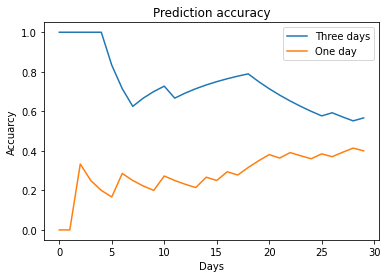

In [386]:
#We evaulte the accuracy by creating this method
def get_accuracy(predicted, actual, days):
  accuracy = []
  correct = 0
  for i in range(days):
    if predicted[i] == actual[i]:
      correct += 1
    accuracy.append(correct/(i+1))
  return accuracy

days_list = np.linspace(0,DAYS-1,num=DAYS).tolist()

acc_one = get_accuracy(predicted_trans, test_trans, DAYS)
acc_three = get_accuracy(predicted_trans_three, test_trans, DAYS)

plt1, = plt.plot(days_list,acc_three)
plt2, = plt.plot(days_list,acc_one)

plt.legend((plt1,plt2), ("Three days","One day"))
plt.title("Prediction accuracy")
plt.xlabel("Days")
plt.ylabel("Accuarcy")

print("Accuracy (Three days): ", round(acc_three[-1],2))
print("Accuracy (One day): ", round(acc_one[-1],2))

We get an accuracy of 57% for the three days state predictions compared to 40% for the one-day predictions: this is a lot better than just guessing each day, where each day, we have 25% of guessing correct.

### Part 3 - Simulating the price of ETH

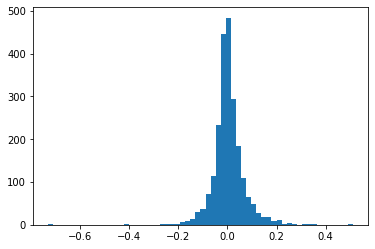

In [378]:
#Let's look at the train data
train_change_rounded = [round(k,2) for k in train['Change']]
plt.hist(train_change_rounded, bins=60)
plt.show()

In [379]:
mean = np.mean(train_change_rounded)
var = np.var(train_change_rounded)
print(f"Mean: {mean}, and variance: {var}.")

Mean: 0.00535904255319149, and variance: 0.004145527116813792.


Our data is normally (Gaussian) distributed with some outliers (which we will ignore this time). For this simulation, we will assume that the high highs and low lows will be exponentially distributed, with similar but opposite means (i.e., mean_ll = -mean_hh). Please, look below. 

HH mean: 0.16053435114503814. LL mean: -0.15833333333333333.


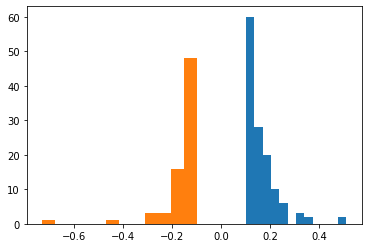

In [380]:
hh_change_rounded = [round(k,2) for k in train['Change'][train['State']=='HH']]
ll_change_rounded = [round(k,2) for k in train['Change'][train['State']=='LL']]

mean_hh = np.mean(hh_change_rounded)
mean_ll = np.mean(ll_change_rounded)
print(f"HH mean: {mean_hh}. LL mean: {mean_ll}.")

plt.hist(hh_change_rounded, bins=12)
plt.hist(ll_change_rounded, bins=12)
plt.show()

We can then simulate this probability distribution by approximating its intensity (lambda) and get the following data (which behaves similarly to the high highs and low lows distribution).

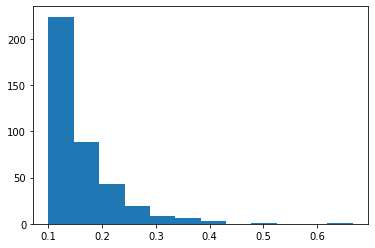

In [381]:
lambd = 1/(mean_hh-0.1)
nums = [] 
for i in range(len(hh_change_rounded*3)): 
    temp = random.expovariate(lambd)+0.1
    nums.append(temp) 
plt.hist(nums, bins = 12) 
plt.show()

In [382]:
#Convert to time series
def get_time_series(prev_price, predictions, mean, var, lambd):
  time_series_price = []
  for pred in predictions:
    if pred == "HH": 
      prev_price = prev_price * (1 + get_random_change(pred, mean, var, lambd))
      time_series_price.append(prev_price)
    elif pred == "LL":
      prev_price = prev_price * (1 - get_random_change(pred, mean, var, lambd))
      time_series_price.append(prev_price)
    elif pred == "MH":
      prev_price = prev_price * (1 + get_random_change(pred, mean, var, lambd))
      time_series_price.append(prev_price)
    else:
      prev_price = prev_price * (1 - get_random_change(pred, mean, var, lambd))
      time_series_price.append(prev_price)
  return time_series_price

def get_random_change(state, mean, var, lambd):
  change = random.normalvariate(mean,var)
  if state == "LL" or state == "HH":
    change = 0.1 + random.expovariate(lambd)
  else:
    while change > 0.1:
      change = abs(random.normalvariate(mean,var))
  return change

In [383]:
time_series_one = get_time_series(last_price, predicted_trans, mean, var, lambd)
time_series_three = get_time_series(last_price, predicted_trans_three, mean, var, lambd)

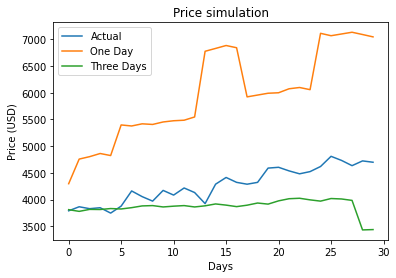

In [384]:
actual, = plt.plot(days_list, test["Open"])
pred_one, = plt.plot(days_list, time_series_one)
pred_three, = plt.plot(days_list, time_series_three)

plt.legend((actual,pred_one, pred_three), ["Actual", "One Day", "Three Days"])

plt.title("Price simulation")
plt.xlabel("Days")
plt.ylabel("Price (USD)")

plt.show()